## TC3007B
### Natural Language Processing

<br>

#### Activity 2: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


#### Install libraries (if needed)

You may need to install the following libraries to ensure version compatibility. After installing them, please Restart the Session (Runtime -> Restart Session)

In [175]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchtext==0.15.2

^C


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install scipy==1.9.3
!pip install scikit-plot
#you may receive a message of restarting session, this is OK

In [ ]:
!pip install portalocker
#please restar session after this intallation. After restarting go straight to importing the libraries

## Import libraries

In [232]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import random
import gc

from tqdm import tqdm

In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [3]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [4]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [5]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [6]:
#test tokens
tokens = tokeniser('Welcome to TC3007B')
print(tokens, vocab(tokens))

['welcome', 'to', 'tc3007b'] [3314, 4, 0]


In [7]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [8]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [9]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [10]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [11]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64) - 1

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [13]:
EMBEDDING_SIZE = 300
NEURONS = 256
LAYERS = 2
NUM_CLASSES = 4

In [15]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        self.rnn = nn.LSTM(embed_size, hidden, layers, batch_first=True)

        self.fc = nn.Linear(hidden, num_classes) 

    def forward(self, x):
        embedded = self.embedding_layer(x)
        _, (h, _) = self.rnn(embedded)

        last = h[-1]

        out = self.fc(last)

        return out


In [39]:
def accuracy(model, loader):
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            preds = model(x)
            predClasses = preds.argmax(dim=1)

            correct += (predClasses == y).sum().item()
            total += y.size(0)

    return correct / total

In [16]:
def train(model, optimiser, epochs=100):
    model = model.to(device)
    model.train()

    def UpdateDesc(pbar, epoch, loss):
        if loss == None:
            pbar.set_description(f'(train): Epoch {epoch:2d}/{epochs} | Loss: {loss}')
        else:
            pbar.set_description(f'(train): Epoch {epoch:2d}/{epochs} | Loss: {loss:.4f}')


    for epoch in range(1, epochs+1):
        avgLoss = 0

        pbar = tqdm(total=len(train_loader))
        UpdateDesc(pbar, epoch, None)
        for x, y in train_loader:
            model.zero_grad()
            
            x=x.to(device) # x (batchsize, maxtokens)
            y=y.to(device) # y (batchsize)
            
            preds = model(x) # (batchsize, maxtokens, numclasses)

            batchLoss = F.cross_entropy(preds, y)

            optimiser.zero_grad()
            batchLoss.backward()
            optimiser.step()

            avgLoss += batchLoss.item() * x.size(0)

            pbar.update(1)

        avgLoss /= len(train_loader.dataset)
        UpdateDesc(pbar, epoch, avgLoss)
        pbar.close()
        
            
            

In [17]:
epochs = 69
lr = 0.001

rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)


In [18]:
train(rnn_model, optimiser=optimiser,  epochs=epochs)

(train): Epoch  1/69 | Loss: 0.6507: 100%|██████████| 422/422 [00:13<00:00, 30.73it/s]
(train): Epoch  2/69 | Loss: 0.2979: 100%|██████████| 422/422 [00:12<00:00, 32.58it/s]
(train): Epoch  3/69 | Loss: 0.2163: 100%|██████████| 422/422 [00:12<00:00, 32.98it/s]
(train): Epoch  4/69 | Loss: 0.1595: 100%|██████████| 422/422 [00:12<00:00, 33.36it/s]
(train): Epoch  5/69 | Loss: 0.1174: 100%|██████████| 422/422 [00:13<00:00, 31.35it/s]
(train): Epoch  6/69 | Loss: 0.0877: 100%|██████████| 422/422 [00:12<00:00, 33.72it/s]
(train): Epoch  7/69 | Loss: 0.0606: 100%|██████████| 422/422 [00:13<00:00, 31.36it/s]
(train): Epoch  8/69 | Loss: 0.0452: 100%|██████████| 422/422 [00:12<00:00, 32.75it/s]
(train): Epoch  9/69 | Loss: 0.0332: 100%|██████████| 422/422 [00:12<00:00, 32.83it/s]
(train): Epoch 10/69 | Loss: 0.0288: 100%|██████████| 422/422 [00:12<00:00, 32.70it/s]
(train): Epoch 11/69 | Loss: 0.0253: 100%|██████████| 422/422 [00:12<00:00, 32.67it/s]
(train): Epoch 12/69 | Loss: 0.0168: 100%|█

In [40]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

0.9095


In [84]:
idx = random.randint(0, len(test_loader.dataset) - 1)
_, text = test_loader.dataset[idx]
print(labels)

x = [vocab(tokeniser(word)) for word in text]
print(len(x))
x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

x = torch.tensor(x, dtype=torch.int64)#, torch.tensor(y, dtype=torch.int64) - 1

print(x[0].shape)


['World', 'Sports', 'Business', 'Sci/Tech']
312
torch.Size([50])


In [184]:
def sample_text(model, loader):
    model = model.to(device)

    # Sample a random article from the dataset
    dataset = loader.dataset
    idx = random.randint(0, len(dataset) - 1)
    label, text = dataset[idx]

    # Tokenize the article
    tokens = vocab(tokeniser(text))

    if len(tokens) < max_tokens:
        # Pad with zeros
        tokens = tokens + ([0] * (max_tokens - len(tokens)))
    else:
        tokens = tokens[:max_tokens]

    x = torch.tensor(tokens, dtype=torch.int64)
    x = x.to(device)

    # Get the prediction
    with torch.no_grad():
        predLabel = model(x).argmax().item()
    
    print('*****')
    print(text)
    print(f'Predicted: {labels[predLabel]}, Real: {labels[label - 1]}')

In [186]:
for _ in range(5):
    sample_text(rnn_model, test_loader)

*****
Older mobiles may cause tumours: study The Institute of Environmental Medicine (IMM) at Karolinska Institute in Sweden found no indications of risk for less than 10 years of usage.
Predicted: Sci/Tech, Real: Sci/Tech
*****
US security official killed in Iraq attack A US security official, assigned to the US Embassy in Baghdad, was killed on Sunday by a mortar attack on a US Army base near Baghdad International Airport, US Secretary of State Colin Powell said.
Predicted: World, Real: World
*****
webcrawler: A9.com is cool NOW heres something else thats off the mind. Theres no more need to make mental or computer notes while searching the Internet.
Predicted: Sci/Tech, Real: Business
*****
AOL Dumping Some Broadband unsupported writes  quot;Just days after news that AOL will be breaking up into 4 business units, AOL is telling existing broadband customers in 9 Southern states to find a new carrier.
Predicted: Sci/Tech, Real: Sci/Tech
*****
UPDATE: Air New Zealand Rights Issue Greet

['World', 'Sports', 'Business', 'Sci/Tech']

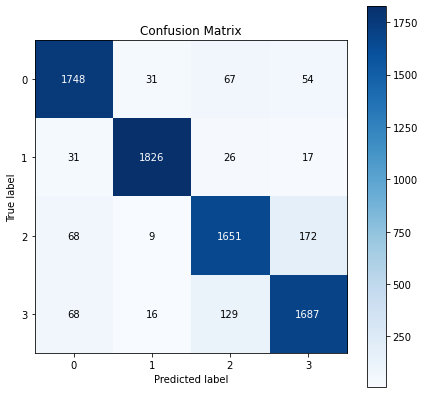

In [ ]:
# create confusion matrix
allLabels = []
allPreds = []

rnn_model = rnn_model.to(device)
rnn_model.eval()

for x, y in test_loader:
    allLabels.append(y)
    with torch.no_grad():
        x = x.to(device)
        allPreds.append(rnn_model(x).argmax(dim=1).to('cpu'))

targets = torch.cat(allLabels, dim=0)
preds   = torch.cat(allPreds, dim=0)

skplt.metrics.plot_confusion_matrix(
    targets,
    preds,
    figsize=(7,7)
)

labels